# NASA Lithium Battery RUL Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import joblib


## Import libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed 
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'nasa_battery'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

## Converting TAG Name Format
* After checking all the Tag Names from the Nasa bearing dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the B0001, B0005, B0007

In [4]:
# Set the desired tag names
tags_1 = ['B0001_Capacity', 'B0001_Current_load', 'B0001_Current_measured', 'B0001_Temperature_measured', 'B0001_Voltage_load', 'B0001_Voltage_measured']
tags_5 = ['B0005_Capacity', 'B0005_Current_load', 'B0005_Current_measured', 'B0005_Temperature_measured', 'B0005_Voltage_load', 'B0005_Voltage_measured']
tags_7 = ['B0007_Capacity', 'B0007_Current_load', 'B0007_Current_measured', 'B0007_Temperature_measured', 'B0007_Voltage_load', 'B0007_Voltage_measured']

# Wrap each item in the list with single quotes and separate with commas
tags_1 = ",".join(f"'{tag}'" for tag in tags_1)
tags_5 = ",".join(f"'{tag}'" for tag in tags_5)
tags_7 = ",".join(f"'{tag}'" for tag in tags_7)

# Check the selected tag names
print(tags_1)
print(tags_5)
print(tags_7)

'B0001_Capacity','B0001_Current_load','B0001_Current_measured','B0001_Temperature_measured','B0001_Voltage_load','B0001_Voltage_measured'
'B0005_Capacity','B0005_Current_load','B0005_Current_measured','B0005_Temperature_measured','B0005_Voltage_load','B0005_Voltage_measured'
'B0007_Capacity','B0007_Current_load','B0007_Current_measured','B0007_Temperature_measured','B0007_Voltage_load','B0007_Voltage_measured'


## Loading NASA Lithium Battery Dataset

In [5]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')
        
    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()
    
    df = df.drop(['TIME'], axis=1)
    
    return df  

In [6]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    target = 'TIME'
    
    # Load the data  
    df = pd.read_csv(f"http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?target={target}&table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}")
    
    # Create a dummy value column for resampling
    df['value'] = 0
    
    # Perform resampling
    df['TIME'] = pd.to_datetime(df['TIME'])
    df.set_index('TIME', inplace=True)
    df = df.resample('1s').mean()
    
    # Remove missing values
    df = df.dropna()
    
    # Remove the dummy value column
    df = df.drop(['value'], axis=1)
    
    return df

In [7]:
# Time update function
# Update start and end times based on batch size
def update_time(time_df, start_time, batch_size):
    
    # Calculate how many data points need to be loaded
    time = batch_size - 1
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time 
    end_time_ = str(time_df.index[index_now + time] + timedelta(seconds=1))
    
    # Set the index number for the next start time
    index_next = index_now + time + 1
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

In [8]:
# Function to calculate the maximum and minimum values for selected tag names
def set_minmax_value(table, name, start_time_train, end_time_train):
    
    # URL encoding
    start = quote(start_time_train)
    end = quote(end_time_train)
    
    # Load Min, Max data
    df_ = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-scale.tql?table={table}&name={name}&start={start}&end={end}')
    
    # Set Min, Max values
    Min = df_.iloc[:,1:-1].T
    Max = df_.iloc[:,2:].T
    
    return Min, Max  

## Data Preprocessing

* 1 MinMax Scaling

### 1. Min-Max Scaling Setup
* Set up a Min-Max Scaler that uses the maximum and minimum values, as the entire dataset is not loaded due to the process concept.

In [9]:
# Definition of the MinMaxScaler class
class MinMaxScaler_custom:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    # Set scale values based on the specified parameters
    def transform(self, X, min_values, max_values):
        X = np.array(X)
        self.min_ = np.array(min_values)
        self.max_ = np.array(max_values)
        
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        scale = (self.max_ - self.min_)
        if np.any(scale == 0):
            scale = (self.max_ - self.min_) + 1e-10
        
        return (X - self.min_) / scale
    
    # Normalize data based on calculated scale values
    def fit_transform(self, X, min_values, max_values):
        """Set parameters and then transform X"""
        return self.transform(X, min_values, max_values)

    # Inverse the normalized data back to original values
    def inverse_transform(self, X_scaled):
        """Inverse the transformation and return original values"""
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        X_scaled = np.array(X_scaled)
        scale = (self.max_ - self.min_)
        
        return X_scaled * scale + self.min_

## Model Configuration
* Using LSTM AE model.

In [10]:
# LSTM Autoencoder class definition
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, 2*hidden_dim)
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        return output

In [11]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0].shape)
input_dim = 6

# LSMT hidden state size
hidden_dim = 4

# layer size
num_layers = 2

# Learning rate 
learning_rate = 0.001

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(6, 4, num_layers=2, batch_first=True)
  (encoder_fc): Linear(in_features=4, out_features=8, bias=True)
  (decoder_fc): Linear(in_features=8, out_features=4, bias=True)
  (decoder_lstm): LSTM(4, 6, num_layers=2, batch_first=True)
)


## Health Index Extranction Model Training

* Save the model with the Best Loss based on the training data during training.

In [12]:
# Model training function
def train(table, name, timeformat, model, batch_size, epochs, Min, Max, scaler1, scaler2, time_df_train):
        
    # Initialize training loss
    train_loss = []

    # Initialize Best Loss value
    best_Loss=np.inf

    for epoch in epochs:
        
        model.train()

        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])

        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next= update_time(time_df_train, start_time_, batch_size)
            
            # Load batch data 
            data = data_load(table, name, start_time_, end_time_, timeformat)
            
            # Apply MinMax scaler
            data_1 = scaler1.fit_transform(data.iloc[:,:1])
            data_2 = scaler2.fit_transform(data.iloc[:,1:], Min.iloc[:,1:], Max.iloc[:,1:])
            
            # Setting up DataFrame
            data_1 = pd.DataFrame(data_1)
            data_2 = pd.DataFrame(data_2)
            data_ = pd.concat([data_1, data_2], axis=1)
            
            # Print if the loaded data is empty 
            if len(data_) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(data_) == batch_size:
                
                # Check total batch count  
                total_step = total_step + 1
                
                # Convert data to numpy arrays
                input_data = np.array(data_)

                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()

                # Optimize the optimizer
                optimizer.zero_grad()
                
                # Input to the model
                outputs = model(input_data.unsqueeze(1))
                
                # Calculate loss
                loss = criterion(outputs, input_data.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                data_ = 0
            
            # Set the next start time   
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + batch_size >= len(time_df_train):
                break
        
        if total_step > 0:
            train_loss.append(running_loss / total_step)
            print(f'\ntrain loss: {np.mean(train_loss)}')
            
        # best model save     
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Nasa_Battery_New_Batch_Health_Index.pt')
            print('Save the best model.') 
            
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
               
    return model, scaler1

In [13]:
########################################### Training Parameter Settings ################################################
# Set the tag table name
table = 'nasa_battery'
# Set the tag names
name_1 = quote(tags_1, safe=":/")
name_5 = quote(tags_5, safe=":/")
name_7 = quote(tags_7, safe=":/")
# Set the start time for the train data
start_time_train = '2010-07-21 15:00:00'
# Set the end time for the train data
end_time_train = '2010-07-21 17:00:00'
# Set time format
timeformat = quote('2006-01-02 15:04:05.000000')
# Set batch size
batch_size = 8
# Set number of epochs
epochs = trange(100, desc='training')
# Set Maximum and Minimum Values 
Min, Max = set_minmax_value(table, name_1, start_time_train, end_time_train)
# Set Min-Max scaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler_custom()
# Load training time list 
time_df_train = time_data_load(table, name_1, quote(start_time_train), quote(end_time_train), timeformat)

########################################### Proceed with training ################################################
model, scaler = train(table, name_1, timeformat, model, batch_size, epochs, Min, Max, scaler1, scaler2, time_df_train)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.306054701082042
Save the best model.

train loss: 0.28541814841207913
Save the best model.

train loss: 0.24739578602418222
Save the best model.

train loss: 0.20528053174741934
Save the best model.

train loss: 0.17478609837469508
Save the best model.

train loss: 0.15314920229297843
Save the best model.

train loss: 0.1372119607992767
Save the best model.

train loss: 0.12502811062455055
Save the best model.

train loss: 0.11542199750028836
Save the best model.

train loss: 0.10765691205675973
Save the best model.

train loss: 0.10125096973126141
Save the best model.

train loss: 0.095876274790737
Save the best model.

train loss: 0.09130211183766061
Save the best model.

train loss: 0.08736159062488506
Save the best model.

train loss: 0.08393112594068378
Save the best model.

train loss: 0.08091730904883751
Save the best model.

train loss: 0.07824824893310049
Save the best model.

train loss: 0.07586771888889116
Save the best model.

train loss: 0.0737311096333218
S

# Health Index Predicition

In [ ]:
# Sliding Window Dataset Configuration
# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

## Health Index Prediction Model Configuration
* Using DLinear model.

In [15]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [ ]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Window size: How many past data points will be used
# Forecast: How many future data points to forecast
window_size = 5
forecast_size= 1

# Model configuration
model_rul = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_rul.parameters(), lr=lr)

# Check the model architecture
print(model_rul)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=5, out_features=1, bias=True)
  (Linear_Seasonal): Linear(in_features=5, out_features=1, bias=True)
)


## Health Index Prediction Model Training

* Save the model with the Best Loss based on the training data during training.

In [17]:
# Health Index Extraction function
def Health_Index_Extraction(table, name, timeformat, model, scaler1, scaler2, time_df_valid, batch_size=batch_size):
        
    # Initialize Health_Index
    Health_Index = []

    with torch.no_grad():
        
        model.eval()

        # Set initial start time
        start_time_ = str(time_df_valid.index[0])
        
        # Set end time
        end_time_valid = str(time_df_valid.index[-1])

        # Use a while loop to call data 
        while start_time_ < end_time_valid:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next= update_time(time_df_valid, start_time_, batch_size)
            
            # Load batch data 
            data = data_load(table, name, start_time_, end_time_, timeformat)
        
            # Apply MinMax scaler
            data_1 = scaler1.fit_transform(data.iloc[:,:1])
            data_2 = scaler2.fit_transform(data.iloc[:,1:], Min.iloc[:,1:], Max.iloc[:,1:])
            
            # Setting up DataFrame
            data_1 = pd.DataFrame(data_1)
            data_2 = pd.DataFrame(data_2)
            data_ = pd.concat([data_1, data_2], axis=1)
            
            # Print if the loaded data is empty 
            if len(data_) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(data_) == batch_size:
                
                # Convert data to numpy arrays
                input_data = np.array(data_)

                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                
                # Input to the Extraction model
                outputs = model(input_data.unsqueeze(1))
                
                # Calculate loss
                loss = criterion(outputs, input_data.unsqueeze(1))
                
                # append Health Index
                Health_Index.append(loss.item())
                
                # Reset batch data
                data_ = []
            
            # Set the next start time   
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + batch_size >= len(time_df_valid):
                break
            
        # Convert Train_Health_Index to a numpy array
        Health_Index = np.array(Health_Index).reshape(-1, 1)
                
    return Health_Index

In [18]:
def train_RUL(model, Health_Index_Train, window_size, forecast_size, batch_size):
    
    # Set up datasets 
    train_x, train_y = time_slide_df(Health_Index_Train, window_size, forecast_size)

    train_ds = Data(train_x, train_y)

    train_dataloader_ = DataLoader(train_ds, batch_size = batch_size, shuffle=False)

    # Initialize loss
    train_loss = []
    # Initialize total step
    total_step = len(train_dataloader_)
    # Set number of epochs
    epoch_in = trange(500, desc='training')
    # Initialize best Loss value
    best_Loss= np.inf

    # Start model training
    for epoch in epoch_in:

        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_dataloader_):
            
            data = data.to(device).float()
            target = target.to(device).float()
            
            optimizer.zero_grad()

            # Input to the model
            outputs = model(data)

            # Calculate loss
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        train_loss.append(running_loss/total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')

        # Save the best model
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Nasa_Battery_New_Batch_RUL.pt')
            print('Model saved')
        epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
        
    return model

In [19]:
########################################### validation Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/Nasa_Battery_New_Batch_Health_Index.pt') 
# Set the start time for the validation data
start_time_valid = '2010-07-21 15:00:00'
# Set the end time for the validation data
end_time_valid = '2010-07-21 17:00:00'

# Load validation time list
time_df_valid = time_data_load(table, name_5, quote(start_time_valid), quote(end_time_valid), timeformat)

# Extraction Health Index
Health_Index_Train = Health_Index_Extraction(table, name_5, timeformat, model_, scaler1, scaler2, time_df_valid, batch_size=8)

# Set up MinMaxScaler
scaler_ = MinMaxScaler()

# Apply MinMax Scaling
Health_Index_Train = scaler_.fit_transform(Health_Index_Train)

# Set DataFrame
Health_Index_Train = Health_Index_Train
Health_Index_Train = pd.DataFrame(Health_Index_Train)

########################################### Proceed with validation ################################################
model_RUL = train_RUL(model_rul, Health_Index_Train, window_size, forecast_size, batch_size=1)

training:   0%|          | 0/500 [00:00<?, ?it/s]


train loss: 0.017992923308232395
Model saved

train loss: 0.016888521230555398
Model saved

train loss: 0.016446808818329828
Model saved

train loss: 0.01610299003463922
Model saved

train loss: 0.01577575475725818
Model saved

train loss: 0.015453837187496057
Model saved

train loss: 0.015137196842712086
Model saved

train loss: 0.014827042480686448
Model saved

train loss: 0.01452426018800647
Model saved

train loss: 0.014229333528056878
Model saved

train loss: 0.01394246585522587
Model saved

train loss: 0.013663691203031804
Model saved

train loss: 0.013392937328004194
Model saved

train loss: 0.013130069641257217
Model saved

train loss: 0.012874919051803995
Model saved

train loss: 0.012627296653624127
Model saved

train loss: 0.012387003148327597
Model saved

train loss: 0.012153834938142807
Model saved

train loss: 0.011927590062449622
Model saved

train loss: 0.011708067156496254
Model saved

train loss: 0.011495070449080018
Model saved

train loss: 0.011288408140027737
Mode

## Model Testing

In [20]:
def test_RUL(model, Health_Index_Test):
    
    # Set up datasets 
    Test_x, Test_y = time_slide_df(Health_Index_Test, window_size, forecast_size)

    Test_ds = Data(Test_x, Test_y)

    Test_dataloader_ = DataLoader(Test_ds, batch_size = 1, shuffle=False)

    # Initial settings 
    output_test = []
    target_test = []

    with torch.no_grad():
        model.eval()
        
        for batch_idx, (data, target) in enumerate(Test_dataloader_):
            
            data_t = data.to(device).float()
            target_t = target.to(device).float()

            outputs_t = model(data_t)
            
            output_test.append(outputs_t)
            target_test.append(target_t)
            
    # Combine tensors into one
    combined_tensor_target = torch.cat(target_test, dim=0)
    combined_tensor_pred = torch.cat(output_test, dim=0)

    # Use only the last value of the window
    last_values_target = combined_tensor_target[:,:1].cpu().numpy().reshape(-1, 1)
    last_values_pred = combined_tensor_pred[:,:1].cpu().numpy().reshape(-1, 1)

        
    return last_values_target, last_values_pred

In [21]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_rul = torch.load(f'./result/Nasa_Battery_New_Batch_RUL.pt') 
# Set the start time for the test data
start_time_test = '2010-07-21 15:00:00'
# Set the end time for the test data
end_time_test = '2010-07-21 17:00:00'
# Load the test time list
time_df_test = time_data_load(table, name_7, quote(start_time_test), quote(end_time_test), timeformat)

# Extraction Health Index
Health_Index_Test = Health_Index_Extraction(table, name_7, timeformat, model_, scaler1, scaler2, time_df_test, batch_size=1)

# Apply MinMax Scaling
Health_Index_Test = scaler_.transform(Health_Index_Test)

# Set DataFrame
Health_Index_Test = Health_Index_Test
Health_Index_Test = pd.DataFrame(Health_Index_Test)

######################################## Proceed with testing #############################################
last_values_target, last_values_pred = test_RUL(model_rul, Health_Index_Test)

## Model Performance Evaluation

In [22]:
# Calculate MSE
mse = mean_squared_error(last_values_target, last_values_pred)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(last_values_target, last_values_pred)
print("R² Score:", r2)

Mean Squared Error: 0.004712619
R² Score: 0.9367224968539963


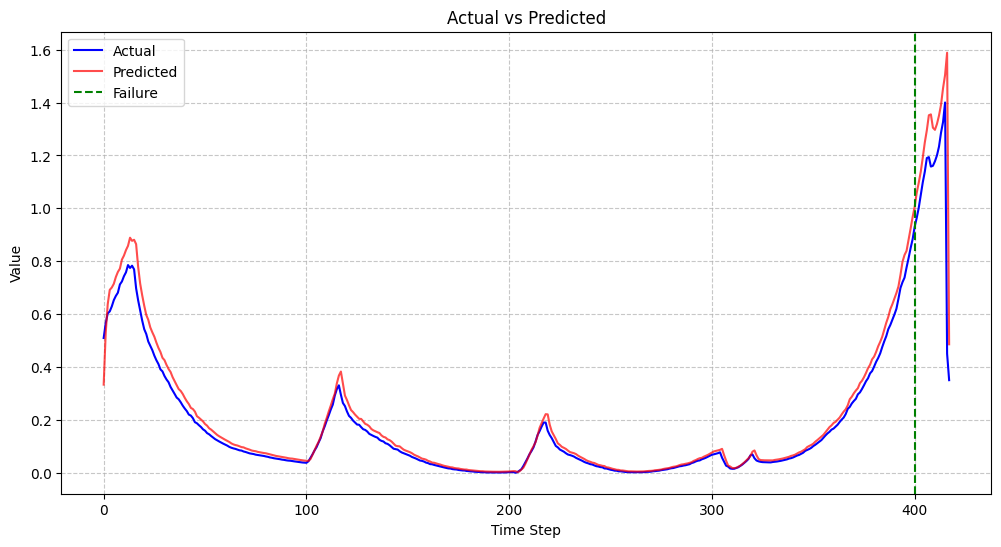

In [23]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(last_values_target, label='Actual', color='blue')
plt.plot(last_values_pred, label='Predicted', color='red', alpha=0.7)

# Add a vertical line at the 400th position (failure point) -> Consider Voltage_measured below 3V as a failure.
plt.axvline(x=400, color='green', linestyle='--', linewidth=1.5, label='Failure')

# Set graph title and axis labels
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Display the graph
plt.show()